In [1]:
from PIL import Image
import numpy as np
import cv2
import torch
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm

import autoregressive_model_oh as autoregressive_model

ModuleNotFoundError: No module named 'cv2'

In [2]:
buffer_states = np.load("Buffer.npz")["states"]
traj_lengths = np.array([np.argmax([(np.zeros(9) == buffer_states[i,j]).all() for j in range(buffer_states.shape[1])] + [True]) for i in range(buffer_states.shape[0])])
length_between_samples = 50

num_trajs_all = 200

Load data and train the model

At epoch 0 the value of the loss is 17.97515106201172
At epoch 400 the value of the loss is 12.191417694091797
At epoch 800 the value of the loss is 11.917882919311523
At epoch 1200 the value of the loss is 12.041775703430176
At epoch 1600 the value of the loss is 11.92756462097168
At epoch 2000 the value of the loss is 11.81495475769043
At epoch 2400 the value of the loss is 11.831035614013672
At epoch 2800 the value of the loss is 11.86935806274414
At epoch 3200 the value of the loss is 11.79309368133545
At epoch 3600 the value of the loss is 11.66082763671875
At epoch 4000 the value of the loss is 11.773029327392578
At epoch 4400 the value of the loss is 11.723751068115234
At epoch 4800 the value of the loss is 11.76785659790039
At epoch 5200 the value of the loss is 11.722765922546387
At epoch 5600 the value of the loss is 11.61536979675293
At epoch 6000 the value of the loss is 11.668089866638184
At epoch 6400 the value of the loss is 11.628534317016602
At epoch 6800 the value of 

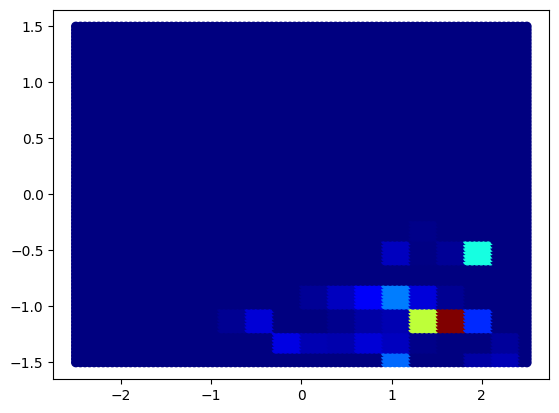

In [14]:
r_vals = np.zeros((10000,))

for ep_no in range(1):
    model = autoregressive_model.AutoRegressiveModel(3, 6, 1024, 3, num_buckets = 20, ac_low = np.array([-3, -2, -1, -3, -2, -1]), ac_high = np.array([3, 2, 1, 3, 2, 1])).cuda()
    optimizer = torch.optim.Adam(model.parameters())

    buffer_states = np.load("Buffer.npz")["states"]
    traj_lengths = np.array([np.argmax([(np.zeros(9) == buffer_states[i,j]).all() for j in range(buffer_states.shape[1])] + [True]) for i in range(buffer_states.shape[0])])
    length_between_samples = 50

#     buffer_states = buffer_states[ep_no*1000:ep_no*1000+1000]
#     buffer_states_new = []

#     def encode(s):
#         num_buckets = 20
#         ac_low = model.ac_low.cpu().numpy()
#         ac_high = model.ac_high.cpu().numpy()
#         bucket_size = (ac_high - ac_low)/num_buckets
#         bucket_idx = (s[:3] - ac_low[:3]) // (bucket_size[:3] + 1e-9)
#         bucket_idx = np.clip(bucket_idx, 0, num_buckets - 1)
#     #     print(bucket_idx)
#         return "$".join([str(int(x)) for x in bucket_idx])

#     for j, traj in enumerate(buffer_states):
#     #     print(j, "of", len(buffer_states))
#         skip = True
#         for s in traj:
#     #         print(s)
#             if encode(s[:3]) == encode(np.array([2, -1, 0])):
#     #             print("In here")
#                 skip = False
#                 break
#         if not skip:
#             print(j)
#             buffer_states_new.append(traj)

    buffer_states = buffer_states[0:8000]
#     buffer_states = list(buffer_states) + buffer_states_new
#     buffer_states = np.asarray(buffer_states)
    
    def sample_visited_batch(batch_size, max_diff):
        """
        Retruns pairs of observations that are at most max_diff timesteps appart
        """

        traj_idxs = np.random.choice(len(buffer_states), batch_size)

        time_idxs_1 = np.random.randint(0, traj_lengths[traj_idxs] - 1)
        time_idxs_2 = np.random.randint(1 + time_idxs_1, np.minimum(traj_lengths[traj_idxs], time_idxs_1 + max_diff + 1))

        observations1 = buffer_states[traj_idxs, time_idxs_1, :3]
        observations2 = buffer_states[traj_idxs, time_idxs_2, :3]

        return observations1, observations2


    def train_autoregressive_model(batch_size=4096, num_epochs=40000, freq_print = None):
        """
        Trains the autoregressive model by sampling pairs of visited states
        """

        if freq_print is None:
            freq_print = num_epochs / 100

        model.trunks.train()
        running_loss = 0.0

        for epoch in range(num_epochs):
            states_1, states_2 = sample_visited_batch(batch_size, length_between_samples)
            optimizer.zero_grad()

            states_1 = torch.Tensor(states_1).cuda()
            states_2 = torch.Tensor(states_2).cuda()
            ins = torch.zeros_like(states_1).cuda()

            states = torch.cat([states_1, states_2], dim=-1)
            loss = -torch.mean(model.log_prob(ins, states))
            loss.backward()
            optimizer.step()

            running_loss += float(loss.item())

            if epoch % freq_print == 0:
                print(f"At epoch {epoch} the value of the loss is {loss}")

        model.trunks.eval()
        return running_loss / num_epochs

    train_autoregressive_model()
    def forward_autoregressive_model(s1, s2):
        states_1 = torch.Tensor(s1).cuda()
        states_2 = torch.Tensor(s2).cuda()
        ins = torch.zeros_like(states_1).cuda()
        vals = torch.cat([states_1, states_2], dim=-1).cuda()
        with torch.no_grad():
            return model.log_prob(ins, vals).detach().cpu().numpy()

    states = np.array(np.meshgrid(np.linspace(-2.5, 2.5, 100), np.linspace(-1.5,1.5,100)))
    states = np.array(states).reshape(2,-1).T
    states = np.array([[states[i,0], states[i,1], 0] for i in range(len(states))])

    start = np.array([2, -1, 0])
    starts = np.array([start for _ in range(100 * 100)])

    r_val = np.exp(np.array(forward_autoregressive_model(starts, states)))
    plt.clf()
    plt.cla()
    plt.scatter(states[:, 0], states[:, 1], c=r_val, cmap=cm.jet)
    print(r_val.max())
    
    r_vals += r_val

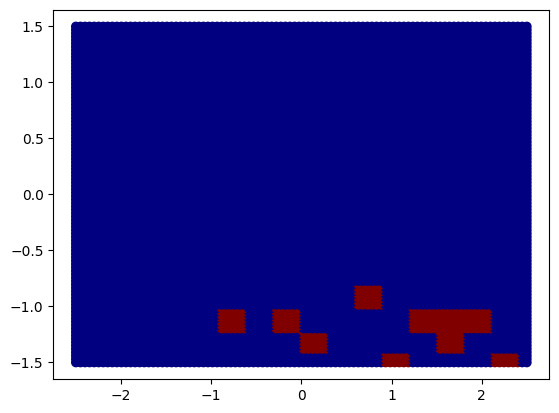

In [4]:
r_valsnew = r_vals > 1e-7
plt.scatter(states[:, 0], states[:, 1], c=r_valsnew, cmap=cm.jet)

In [5]:
model = autoregressive_model.AutoRegressiveModel(3, 6, 1024, 3, num_buckets = 20, ac_low = np.array([-3, -2, -1, -3, -2, -1]), ac_high = np.array([3, 2, 1, 3, 2, 1])).cuda()
optimizer = torch.optim.Adam(model.parameters())

In [6]:
buffer_states = np.load("Buffer.npz")["states"]
traj_lengths = np.array([np.argmax([(np.zeros(9) == buffer_states[i,j]).all() for j in range(buffer_states.shape[1])] + [True]) for i in range(buffer_states.shape[0])])
length_between_samples = 50

In [7]:
buffer_states = buffer_states[0:8000]

Compute densities

In [8]:
total_visited = 0

def encode(s):
    num_buckets = 20
    ac_low = model.ac_low.cpu().numpy()
    ac_high = model.ac_high.cpu().numpy()
    bucket_size = (ac_high - ac_low)/num_buckets
    bucket_idx = (s[:3] - ac_low[:3]) // (bucket_size[:3] + 1e-9)
    bucket_idx = np.clip(bucket_idx, 0, num_buckets - 1)
#     print(bucket_idx)
    return "$".join([str(int(x)) for x in bucket_idx])

def query(x, y):
    global total_visited
    encoded1 = encode(x)
    encoded2 = encode(y)

    key = encoded1 + "&" + encoded2
    
    if key in visited:
        return visited[key]/float(total_visited)
    else:
        return 0

def add_pair(x, y):
    global total_visited
    encoded1 = encode(x)
    encoded2 = encode(y)

    key = encoded1 + "&" + encoded2
    
    if key in visited:
        visited[key] += 1
    else:
        visited[key] = 1
    
    total_visited += 1

def add_traj(traj):
    L = len(traj)
    for i in range(L):
        for j in range(i+1, min(L, i + length_between_samples + 1)):
            add_pair(traj[i], traj[j])


In [9]:
visited = dict()

for i, traj in enumerate(buffer_states):
    print(i, 'of', len(buffer_states))
    add_traj(traj)

0 of 6981
1 of 6981
2 of 6981
3 of 6981
4 of 6981
5 of 6981
6 of 6981
7 of 6981
8 of 6981
9 of 6981
10 of 6981
11 of 6981
12 of 6981
13 of 6981
14 of 6981
15 of 6981
16 of 6981
17 of 6981
18 of 6981
19 of 6981
20 of 6981
21 of 6981
22 of 6981
23 of 6981
24 of 6981
25 of 6981
26 of 6981
27 of 6981
28 of 6981
29 of 6981
30 of 6981
31 of 6981
32 of 6981
33 of 6981
34 of 6981
35 of 6981
36 of 6981
37 of 6981
38 of 6981
39 of 6981
40 of 6981
41 of 6981
42 of 6981
43 of 6981
44 of 6981
45 of 6981
46 of 6981
47 of 6981
48 of 6981
49 of 6981
50 of 6981
51 of 6981
52 of 6981
53 of 6981
54 of 6981
55 of 6981
56 of 6981
57 of 6981
58 of 6981
59 of 6981
60 of 6981
61 of 6981
62 of 6981
63 of 6981
64 of 6981
65 of 6981
66 of 6981
67 of 6981
68 of 6981
69 of 6981
70 of 6981
71 of 6981
72 of 6981
73 of 6981
74 of 6981
75 of 6981
76 of 6981
77 of 6981
78 of 6981
79 of 6981
80 of 6981
81 of 6981
82 of 6981
83 of 6981
84 of 6981
85 of 6981
86 of 6981
87 of 6981
88 of 6981
89 of 6981
90 of 6981
91 of 698

695 of 6981
696 of 6981
697 of 6981
698 of 6981
699 of 6981
700 of 6981
701 of 6981
702 of 6981
703 of 6981
704 of 6981
705 of 6981
706 of 6981
707 of 6981
708 of 6981
709 of 6981
710 of 6981
711 of 6981
712 of 6981
713 of 6981
714 of 6981
715 of 6981
716 of 6981
717 of 6981
718 of 6981
719 of 6981
720 of 6981
721 of 6981
722 of 6981
723 of 6981
724 of 6981
725 of 6981
726 of 6981
727 of 6981
728 of 6981
729 of 6981
730 of 6981
731 of 6981
732 of 6981
733 of 6981
734 of 6981
735 of 6981
736 of 6981
737 of 6981
738 of 6981
739 of 6981
740 of 6981
741 of 6981
742 of 6981
743 of 6981
744 of 6981
745 of 6981
746 of 6981
747 of 6981
748 of 6981
749 of 6981
750 of 6981
751 of 6981
752 of 6981
753 of 6981
754 of 6981
755 of 6981
756 of 6981
757 of 6981
758 of 6981
759 of 6981
760 of 6981
761 of 6981
762 of 6981
763 of 6981
764 of 6981
765 of 6981
766 of 6981
767 of 6981
768 of 6981
769 of 6981
770 of 6981
771 of 6981
772 of 6981
773 of 6981
774 of 6981
775 of 6981
776 of 6981
777 of 6981
778 

1349 of 6981
1350 of 6981
1351 of 6981
1352 of 6981
1353 of 6981
1354 of 6981
1355 of 6981
1356 of 6981
1357 of 6981
1358 of 6981
1359 of 6981
1360 of 6981
1361 of 6981
1362 of 6981
1363 of 6981
1364 of 6981
1365 of 6981
1366 of 6981
1367 of 6981
1368 of 6981
1369 of 6981
1370 of 6981
1371 of 6981
1372 of 6981
1373 of 6981
1374 of 6981
1375 of 6981
1376 of 6981
1377 of 6981
1378 of 6981
1379 of 6981
1380 of 6981
1381 of 6981
1382 of 6981
1383 of 6981
1384 of 6981
1385 of 6981
1386 of 6981
1387 of 6981
1388 of 6981
1389 of 6981
1390 of 6981
1391 of 6981
1392 of 6981
1393 of 6981
1394 of 6981
1395 of 6981
1396 of 6981
1397 of 6981
1398 of 6981
1399 of 6981
1400 of 6981
1401 of 6981
1402 of 6981
1403 of 6981
1404 of 6981
1405 of 6981
1406 of 6981
1407 of 6981
1408 of 6981
1409 of 6981
1410 of 6981
1411 of 6981
1412 of 6981
1413 of 6981
1414 of 6981
1415 of 6981
1416 of 6981
1417 of 6981
1418 of 6981
1419 of 6981
1420 of 6981
1421 of 6981
1422 of 6981
1423 of 6981
1424 of 6981
1425 of 6981

1982 of 6981
1983 of 6981
1984 of 6981
1985 of 6981
1986 of 6981
1987 of 6981
1988 of 6981
1989 of 6981
1990 of 6981
1991 of 6981
1992 of 6981
1993 of 6981
1994 of 6981
1995 of 6981
1996 of 6981
1997 of 6981
1998 of 6981
1999 of 6981
2000 of 6981
2001 of 6981
2002 of 6981
2003 of 6981
2004 of 6981
2005 of 6981
2006 of 6981
2007 of 6981
2008 of 6981
2009 of 6981
2010 of 6981
2011 of 6981
2012 of 6981
2013 of 6981
2014 of 6981
2015 of 6981
2016 of 6981
2017 of 6981
2018 of 6981
2019 of 6981
2020 of 6981
2021 of 6981
2022 of 6981
2023 of 6981
2024 of 6981
2025 of 6981
2026 of 6981
2027 of 6981
2028 of 6981
2029 of 6981
2030 of 6981
2031 of 6981
2032 of 6981
2033 of 6981
2034 of 6981
2035 of 6981
2036 of 6981
2037 of 6981
2038 of 6981
2039 of 6981
2040 of 6981
2041 of 6981
2042 of 6981
2043 of 6981
2044 of 6981
2045 of 6981
2046 of 6981
2047 of 6981
2048 of 6981
2049 of 6981
2050 of 6981
2051 of 6981
2052 of 6981
2053 of 6981
2054 of 6981
2055 of 6981
2056 of 6981
2057 of 6981
2058 of 6981

2616 of 6981
2617 of 6981
2618 of 6981
2619 of 6981
2620 of 6981
2621 of 6981
2622 of 6981
2623 of 6981
2624 of 6981
2625 of 6981
2626 of 6981
2627 of 6981
2628 of 6981
2629 of 6981
2630 of 6981
2631 of 6981
2632 of 6981
2633 of 6981
2634 of 6981
2635 of 6981
2636 of 6981
2637 of 6981
2638 of 6981
2639 of 6981
2640 of 6981
2641 of 6981
2642 of 6981
2643 of 6981
2644 of 6981
2645 of 6981
2646 of 6981
2647 of 6981
2648 of 6981
2649 of 6981
2650 of 6981
2651 of 6981
2652 of 6981
2653 of 6981
2654 of 6981
2655 of 6981
2656 of 6981
2657 of 6981
2658 of 6981
2659 of 6981
2660 of 6981
2661 of 6981
2662 of 6981
2663 of 6981
2664 of 6981
2665 of 6981
2666 of 6981
2667 of 6981
2668 of 6981
2669 of 6981
2670 of 6981
2671 of 6981
2672 of 6981
2673 of 6981
2674 of 6981
2675 of 6981
2676 of 6981
2677 of 6981
2678 of 6981
2679 of 6981
2680 of 6981
2681 of 6981
2682 of 6981
2683 of 6981
2684 of 6981
2685 of 6981
2686 of 6981
2687 of 6981
2688 of 6981
2689 of 6981
2690 of 6981
2691 of 6981
2692 of 6981

3249 of 6981
3250 of 6981
3251 of 6981
3252 of 6981
3253 of 6981
3254 of 6981
3255 of 6981
3256 of 6981
3257 of 6981
3258 of 6981
3259 of 6981
3260 of 6981
3261 of 6981
3262 of 6981
3263 of 6981
3264 of 6981
3265 of 6981
3266 of 6981
3267 of 6981
3268 of 6981
3269 of 6981
3270 of 6981
3271 of 6981
3272 of 6981
3273 of 6981
3274 of 6981
3275 of 6981
3276 of 6981
3277 of 6981
3278 of 6981
3279 of 6981
3280 of 6981
3281 of 6981
3282 of 6981
3283 of 6981
3284 of 6981
3285 of 6981
3286 of 6981
3287 of 6981
3288 of 6981
3289 of 6981
3290 of 6981
3291 of 6981
3292 of 6981
3293 of 6981
3294 of 6981
3295 of 6981
3296 of 6981
3297 of 6981
3298 of 6981
3299 of 6981
3300 of 6981
3301 of 6981
3302 of 6981
3303 of 6981
3304 of 6981
3305 of 6981
3306 of 6981
3307 of 6981
3308 of 6981
3309 of 6981
3310 of 6981
3311 of 6981
3312 of 6981
3313 of 6981
3314 of 6981
3315 of 6981
3316 of 6981
3317 of 6981
3318 of 6981
3319 of 6981
3320 of 6981
3321 of 6981
3322 of 6981
3323 of 6981
3324 of 6981
3325 of 6981

3883 of 6981
3884 of 6981
3885 of 6981
3886 of 6981
3887 of 6981
3888 of 6981
3889 of 6981
3890 of 6981
3891 of 6981
3892 of 6981
3893 of 6981
3894 of 6981
3895 of 6981
3896 of 6981
3897 of 6981
3898 of 6981
3899 of 6981
3900 of 6981
3901 of 6981
3902 of 6981
3903 of 6981
3904 of 6981
3905 of 6981
3906 of 6981
3907 of 6981
3908 of 6981
3909 of 6981
3910 of 6981
3911 of 6981
3912 of 6981
3913 of 6981
3914 of 6981
3915 of 6981
3916 of 6981
3917 of 6981
3918 of 6981
3919 of 6981
3920 of 6981
3921 of 6981
3922 of 6981
3923 of 6981
3924 of 6981
3925 of 6981
3926 of 6981
3927 of 6981
3928 of 6981
3929 of 6981
3930 of 6981
3931 of 6981
3932 of 6981
3933 of 6981
3934 of 6981
3935 of 6981
3936 of 6981
3937 of 6981
3938 of 6981
3939 of 6981
3940 of 6981
3941 of 6981
3942 of 6981
3943 of 6981
3944 of 6981
3945 of 6981
3946 of 6981
3947 of 6981
3948 of 6981
3949 of 6981
3950 of 6981
3951 of 6981
3952 of 6981
3953 of 6981
3954 of 6981
3955 of 6981
3956 of 6981
3957 of 6981
3958 of 6981
3959 of 6981

4517 of 6981
4518 of 6981
4519 of 6981
4520 of 6981
4521 of 6981
4522 of 6981
4523 of 6981
4524 of 6981
4525 of 6981
4526 of 6981
4527 of 6981
4528 of 6981
4529 of 6981
4530 of 6981
4531 of 6981
4532 of 6981
4533 of 6981
4534 of 6981
4535 of 6981
4536 of 6981
4537 of 6981
4538 of 6981
4539 of 6981
4540 of 6981
4541 of 6981
4542 of 6981
4543 of 6981
4544 of 6981
4545 of 6981
4546 of 6981
4547 of 6981
4548 of 6981
4549 of 6981
4550 of 6981
4551 of 6981
4552 of 6981
4553 of 6981
4554 of 6981
4555 of 6981
4556 of 6981
4557 of 6981
4558 of 6981
4559 of 6981
4560 of 6981
4561 of 6981
4562 of 6981
4563 of 6981
4564 of 6981
4565 of 6981
4566 of 6981
4567 of 6981
4568 of 6981
4569 of 6981
4570 of 6981
4571 of 6981
4572 of 6981
4573 of 6981
4574 of 6981
4575 of 6981
4576 of 6981
4577 of 6981
4578 of 6981
4579 of 6981
4580 of 6981
4581 of 6981
4582 of 6981
4583 of 6981
4584 of 6981
4585 of 6981
4586 of 6981
4587 of 6981
4588 of 6981
4589 of 6981
4590 of 6981
4591 of 6981
4592 of 6981
4593 of 6981

5151 of 6981
5152 of 6981
5153 of 6981
5154 of 6981
5155 of 6981
5156 of 6981
5157 of 6981
5158 of 6981
5159 of 6981
5160 of 6981
5161 of 6981
5162 of 6981
5163 of 6981
5164 of 6981
5165 of 6981
5166 of 6981
5167 of 6981
5168 of 6981
5169 of 6981
5170 of 6981
5171 of 6981
5172 of 6981
5173 of 6981
5174 of 6981
5175 of 6981
5176 of 6981
5177 of 6981
5178 of 6981
5179 of 6981
5180 of 6981
5181 of 6981
5182 of 6981
5183 of 6981
5184 of 6981
5185 of 6981
5186 of 6981
5187 of 6981
5188 of 6981
5189 of 6981
5190 of 6981
5191 of 6981
5192 of 6981
5193 of 6981
5194 of 6981
5195 of 6981
5196 of 6981
5197 of 6981
5198 of 6981
5199 of 6981
5200 of 6981
5201 of 6981
5202 of 6981
5203 of 6981
5204 of 6981
5205 of 6981
5206 of 6981
5207 of 6981
5208 of 6981
5209 of 6981
5210 of 6981
5211 of 6981
5212 of 6981
5213 of 6981
5214 of 6981
5215 of 6981
5216 of 6981
5217 of 6981
5218 of 6981
5219 of 6981
5220 of 6981
5221 of 6981
5222 of 6981
5223 of 6981
5224 of 6981
5225 of 6981
5226 of 6981
5227 of 6981

5785 of 6981
5786 of 6981
5787 of 6981
5788 of 6981
5789 of 6981
5790 of 6981
5791 of 6981
5792 of 6981
5793 of 6981
5794 of 6981
5795 of 6981
5796 of 6981
5797 of 6981
5798 of 6981
5799 of 6981
5800 of 6981
5801 of 6981
5802 of 6981
5803 of 6981
5804 of 6981
5805 of 6981
5806 of 6981
5807 of 6981
5808 of 6981
5809 of 6981
5810 of 6981
5811 of 6981
5812 of 6981
5813 of 6981
5814 of 6981
5815 of 6981
5816 of 6981
5817 of 6981
5818 of 6981
5819 of 6981
5820 of 6981
5821 of 6981
5822 of 6981
5823 of 6981
5824 of 6981
5825 of 6981
5826 of 6981
5827 of 6981
5828 of 6981
5829 of 6981
5830 of 6981
5831 of 6981
5832 of 6981
5833 of 6981
5834 of 6981
5835 of 6981
5836 of 6981
5837 of 6981
5838 of 6981
5839 of 6981
5840 of 6981
5841 of 6981
5842 of 6981
5843 of 6981
5844 of 6981
5845 of 6981
5846 of 6981
5847 of 6981
5848 of 6981
5849 of 6981
5850 of 6981
5851 of 6981
5852 of 6981
5853 of 6981
5854 of 6981
5855 of 6981
5856 of 6981
5857 of 6981
5858 of 6981
5859 of 6981
5860 of 6981
5861 of 6981

6418 of 6981
6419 of 6981
6420 of 6981
6421 of 6981
6422 of 6981
6423 of 6981
6424 of 6981
6425 of 6981
6426 of 6981
6427 of 6981
6428 of 6981
6429 of 6981
6430 of 6981
6431 of 6981
6432 of 6981
6433 of 6981
6434 of 6981
6435 of 6981
6436 of 6981
6437 of 6981
6438 of 6981
6439 of 6981
6440 of 6981
6441 of 6981
6442 of 6981
6443 of 6981
6444 of 6981
6445 of 6981
6446 of 6981
6447 of 6981
6448 of 6981
6449 of 6981
6450 of 6981
6451 of 6981
6452 of 6981
6453 of 6981
6454 of 6981
6455 of 6981
6456 of 6981
6457 of 6981
6458 of 6981
6459 of 6981
6460 of 6981
6461 of 6981
6462 of 6981
6463 of 6981
6464 of 6981
6465 of 6981
6466 of 6981
6467 of 6981
6468 of 6981
6469 of 6981
6470 of 6981
6471 of 6981
6472 of 6981
6473 of 6981
6474 of 6981
6475 of 6981
6476 of 6981
6477 of 6981
6478 of 6981
6479 of 6981
6480 of 6981
6481 of 6981
6482 of 6981
6483 of 6981
6484 of 6981
6485 of 6981
6486 of 6981
6487 of 6981
6488 of 6981
6489 of 6981
6490 of 6981
6491 of 6981
6492 of 6981
6493 of 6981
6494 of 6981

In [10]:
state0 = np.array([2, -1, 0])
density = np.array([query(state0, x) for x in buffer_states[:,0,:3]])

In [11]:
np.asarray(visited.values()).max()

dict_values([21, 2, 3, 1, 1, 1, 5, 4, 3, 4, 3, 1, 3, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 276, 21, 3, 1, 1, 2, 8, 6, 3, 8, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 177, 6, 1, 3, 5, 4, 4, 4, 15, 15, 2, 3, 6, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 177, 7, 7, 3, 6, 4, 6, 6, 6, 8, 6, 4, 9, 3, 3, 3, 6, 3, 3, 3, 6, 3, 3, 3, 3, 3, 4, 6, 5, 3, 3, 3, 35, 7, 1, 1, 1, 3, 3, 2, 4, 2, 1, 3, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 5, 4, 1, 5, 3, 19, 18, 17, 15, 46, 39, 23, 16, 12, 3, 6, 2, 8, 2, 12, 11, 6, 7, 7, 8, 1, 1, 1, 1, 1, 1, 1, 1, 220, 17, 16, 48, 58, 31, 7, 10, 11, 12, 1, 7, 10, 6, 3, 6, 4, 2, 5, 7, 5, 2, 1, 1, 1, 1, 1, 186, 49, 37, 85, 83, 63, 40, 30, 12, 25, 9, 15, 11, 16, 25, 9, 10, 6, 10, 5, 2, 2, 2, 2, 2, 2, 2, 390, 54, 64, 97, 90, 85, 32, 15, 21, 18, 2, 18, 12, 3, 7, 4, 2, 11, 8, 2, 4, 2, 2, 2, 2, 2, 2, 442, 346, 232, 160, 87, 31, 19, 27, 2, 25, 20, 6, 11, 7, 5, 10, 12, 2, 9, 7, 5, 2, 5, 2, 2, 1186, 172, 84, 27, 24, 41, 

Compare distributions visually

In [12]:
states = np.array(np.meshgrid(np.linspace(-2.5, 2.5, 100), np.linspace(-1.5,1.5,100)))
states = np.array(states).reshape(2,-1).T
states = np.array([[states[i,0], states[i,1], 0] for i in range(len(states))])

start = np.array([2, -1, 0])
starts = np.array([start for _ in range(100 * 100)])

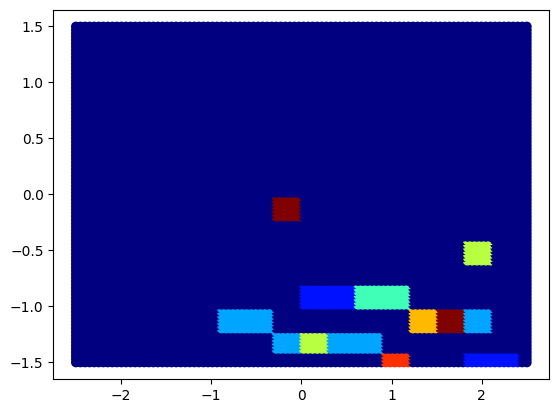

In [13]:
r_val = np.array([query(starts[i], states[i]) for i in range(len(starts))])
plt.clf()
plt.cla()
plt.scatter(states[:, 0], states[:, 1], c=r_val, cmap=cm.jet)